# Lemmatisierer Evaluierung

## Inhalt
1. [Einlesen der Ausgaben](#Einlesen)
2. [Beschreibung der Datensätze](#Datensätze)
3. [Ergebnisse und Analysen](#Ergebnisse)
    - [Allgemein](#Accuracy)
    - [Zeit-, Speicher-, Energieverbrauch](#Energieverbrauchsaspekte)
    - [Ergebnisse nach PoS-Tags](#PoS-Tags)

## Einlesen

In [5]:
import glob
import json
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [6]:
# read emission files
FILES = glob.glob("emissions/emissions-*.csv")
emissions = pd.DataFrame()
for FILE in FILES:
    edf = pd.read_csv(FILE)
    emissions = pd.concat([emissions, edf], axis=0)

In [7]:
FILES = glob.glob("results-*.json")
data = []
algos = []
corpora = []
for FILE in FILES:
    algos.append(FILE.split('.')[0].split('results-')[1])
    with open(FILE, "r") as fp:
        results = json.load(fp)
        for r in results:
            lem = r['lemmatizer']
            ds = r['dataset']
            # extract time and energy from emission files
            if list(emissions[emissions['project_name'] == f'{lem}-{ds}'].duration):
                r['elapsed'] = list(emissions[emissions['project_name'] == f'{lem}-{ds}'].duration)[-1]
                r['energy_consumed'] = list(emissions[emissions['project_name'] == f'{lem}-{ds}'].energy_consumed)[-1]
                r['cpu_energy'] = list(emissions[emissions['project_name'] == f'{lem}-{ds}'].cpu_energy)[-1]
                r['ram_energy'] = list(emissions[emissions['project_name'] == f'{lem}-{ds}'].ram_energy)[-1]
            else:
                r['elapsed'] = 0
                r['energy_consumed'] = 0  # sum of cpu_energy, gpu_energy and ram_energy (kW) 
                r['cpu_energy'] = 0  # cpu_energy (kW)
                r['ram_energy'] = 0  # ram_energy (kW)
        data += results
        print(len(results))
        if algos[-1] == 'baseline':
            corpora = [f['dataset'] for f in results]
        if len(results) != len(corpora) and len(results) != 0:  # check for unlemmatized datasets
            print(set(corpora).difference(set([f['dataset'] for f in results])))

36
36
31
{'ud-hdt', 'tgermacorp', 'germanc', 'ud-pud', 'germanc-norm'}
36
36
35
{'ud-hdt'}
36
36
36
36
36
34
{'empirist-web', 'empirist-web-norm'}
34
{'empirist-web', 'empirist-web-norm'}
36
36


In [8]:
len(data)

530

## Datensätze

In [9]:
datasets = pd.DataFrame(columns=['corpus', 'size', 'lemma tokens', 'lemma types'])
for d in data[:36]:  # baseline files
    if 'norm' in d['dataset']:  # only original file
        continue
    line = [d['dataset'], d['sample-size'], d['metrics']['overall']['number_of_lemmata'],
           d['metrics']['overall']['true-pred-types'][0]]
    datasets.loc[len(datasets)] = line
datasets = datasets.set_index('corpus')
datasets['lemma-type-token-ratio'] = (datasets['lemma types'] / datasets['lemma tokens']) * 100
datasets['lemma-type-token-ratio'] = datasets['lemma-type-token-ratio'].apply(lambda x: round (x,2))

In [10]:
datasets

,size,lemma tokens,lemma types,lemma-type-token-ratio
corpus,,,,
ud-gsd,15229,7060,3853,54.58
ud-pud,21304,9831,4980,50.66
ud-hdt,321919,151291,16640,11.00
germanc,54915,23683,6292,26.57
nosta-d-tuebadz-orig,5415,2464,1503,61.00
nosta-d-anselm-orig,1355,558,202,36.20
nosta-d-kafka-orig,5194,1959,842,42.98
nosta-d-bematac-orig,8122,2932,566,19.30
nosta-d-unicum-orig,5655,1811,753,41.58


* higher lemma TTR -> more varied vocabulary (more types)
* lowest: HDT (11%), Bematac (19%), TGermacorp (24%)
* highest: Empirist-Blog (84%), RUB2019-Wikipedia (80%)

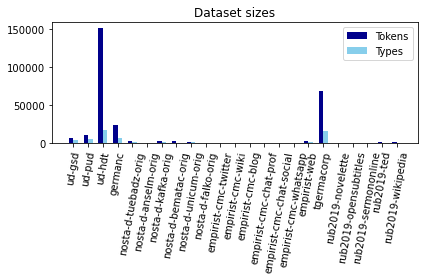

In [11]:
labels = datasets.index
tokens = datasets['lemma tokens']
types = datasets['lemma types']

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, tokens, width, label='Tokens', color="darkblue")
rects2 = ax.bar(x + width/2, types, width, label='Types', color="skyblue")

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('Scores')
ax.set_title('Dataset sizes')
ax.set_xticks(x)#, labels
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=80)

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

## Ergebnisse

In [34]:
def generate_table(df, feature, latex=False, plot=True, round_results=4):
    table = pd.DataFrame(columns=['algorithm']+corpora)
    line = []
    algo_index = 0
    corpus_index = 0
    for d in data:
        corpus = d['dataset']
        # some corpora not lemmatized by some algorithms
        if corpora[corpus_index] != corpus:
            while corpora[corpus_index] != corpus:
                line.append(0.)
                corpus_index += 1
        if type(feature) == str:
            line.append(d[feature])
        elif type(feature) == list:
            if feature[0] and feature[1]:
                if feature[2]:
                    if len(feature) > 3:
                        line.append(d[feature[0]][feature[1]][feature[2]][feature[3]])
                    else:
                        line.append(d[feature[0]][feature[1]][feature[2]])
                else:
                    line.append(d[feature[0]][feature[1]])
        corpus_index += 1  # next corpus
        if corpus_index == 36:  # last corpus reached, next algorithm
            table.loc[len(table)] = [d['lemmatizer']] + line
            line = []
            algo_index += 1  # next algorithm
            corpus_index = 0  # start again with first corpus
    table = table.set_index('algorithm')
    table = table.astype(float)
    if round_results:
        table = table.apply(lambda x: round (x,round_results))
    if latex:
        print(table.to_latex(bold_rows=True))
    if plot:
        sns.heatmap(table, cmap="YlGnBu")
    return table

Zusammenfassung der Ergebnisse auf allen Korpora (ungewichtet):

In [65]:
# resume all corpora
df2 = pd.DataFrame(columns=['algorithm', 'time', 'memory', 'energy_consumed', 'accuracy', 'bal_accuracy', 'adj_precision',
                            'adj_recall', 'adj_f1', 'levenshtein', 'type-ratio'])
current_algo = 'baseline'
time, memory, energy_consumed, acc, bal_acc, adj_pre, adj_re, adj_f1, leven, types = [], [], [], [], [], [], [], [], [], []

for d in data: 
    if d["lemmatizer"] != current_algo or (data.index(d) == len(data)-1):  # next algorithm
        #print(time)
        line = [current_algo]
        try:
            line.append(np.nanmean(time))
        except Exception as e:
            line.append('-')
            print(e)
        try:
            line.append(np.nanmean(memory))
        except Exception as e:
            line.append('-')
            print(e)
        try:
            line.append(np.nanmean(energy_consumed))
        except Exception as e:
            line.append('-')
            print(e)
        try:
            line.append(np.nanmean(acc))
        except Exception as e:
            line.append('-')
            print(e)
        try:
            line.append(np.nanmean(bal_acc))
        except Exception as e:
            line.append('-')
            print(e)
        try:
            line.append(np.nanmean(adj_pre))
        except Exception as e:
            line.append('-')
            print(e)
        try:
            line.append(np.nanmean(adj_re))
        except Exception as e:
            line.append('-')
            print(e)
        try:
            line.append(np.nanmean(adj_f1))
        except Exception as e:
            line.append('-')
            print(e)
        try:
            line.append(np.nanmean(leven))
        except Exception as e:
            line.append('-')
            print(e)
        try:
            line.append(np.nanmean(types))
        except Exception as e:
            line.append('-')
            print(e)
        df2.loc[len(df2)] = line
        current_algo = d["lemmatizer"]
        time, memory, energy_consumed, acc, adj_acc, adj_pre, adj_re, adj_f1, leven, types = [], [], [], [], [], [], [], [], [], []
    time.append(d["elapsed"])
    memory.append(d["memory_peak"])
    energy_consumed.append(d["energy_consumed"])
    acc.append(d['metrics']['overall']['accuracy'])
    bal_acc.append(d['metrics']['overall']['bal_accuracy'])
    adj_pre.append(d['metrics']['overall']['adj_precision'])
    adj_re.append(d['metrics']['overall']['adj_recall'])
    adj_f1.append(d['metrics']['overall']['adj_f1'])
    leven.append(d['metrics']['overall']['levenshtein'])
    types.append(d['metrics']['overall']['true-pred-types'][2])
    
df2 = df2.set_index('algorithm')

unsupported operand type(s) for +: 'float' and 'NoneType'
unsupported operand type(s) for +: 'float' and 'NoneType'


In [66]:
df2

,time,memory,energy_consumed,accuracy,bal_accuracy,adj_precision,adj_recall,adj_f1,levenshtein,type-ratio
algorithm,,,,,,,,,,
baseline,0.0025,12.2222,0.0000,0.5855,0.5889,0.4191,0.3927,0.3985,0.8908,0.8397
germalemma,0.1413,1823125.5278,0.0000,0.8075,0.6905,0.7232,0.7189,0.7187,0.7851,1.0590
gpt3,0.0000,0.0000,0.0000,0.8376,0.7308,0.7148,0.7021,0.7046,0.3617,0.9573
hanta-pretagged,4.6039,1801174.6389,0.0003,0.8599,0.7569,0.7302,0.7291,0.7276,0.3280,0.9821
hanta,8.6539,1297719.0000,0.0005,0.8457,0.7690,0.7092,0.7087,0.7066,0.3655,0.9849
rnntagger,24.5101,946643.5143,0.0016,0.8614,0.7806,0.7551,0.7487,0.7492,-,0.9673
simplemma,0.0769,5459175.8611,0.0000,0.8465,0.7858,0.7048,0.6985,0.6985,0.3791,0.9624
smorlemma,24715.3279,771321.5000,1.5983,0.8871,0.7961,0.8743,0.8644,0.8676,0.7949,1.2746
spacy2,3.0328,19229625.9722,0.0002,0.8002,0.7936,0.6454,0.6336,0.6354,0.4425,0.9346


In [67]:
#pd.set_option('display.float_format', '{:.4f}'.format)
print(df2[['time', 'memory', 'energy_consumed']].apply(lambda x: round (x,4)).to_latex(bold_rows=True))

\begin{tabular}{lrrr}
\toprule
{} &       time &        memory &  energy\_consumed \\
\textbf{algorithm       } &            &               &                  \\
\midrule
\textbf{baseline        } &     0.0025 &       12.2222 &           0.0000 \\
\textbf{germalemma      } &     0.1413 &  1823125.5278 &           0.0000 \\
\textbf{gpt3            } &     0.0000 &        0.0000 &           0.0000 \\
\textbf{hanta-pretagged } &     4.6039 &  1801174.6389 &           0.0003 \\
\textbf{hanta           } &     8.6539 &  1297719.0000 &           0.0005 \\
\textbf{rnntagger       } &    24.5101 &   946643.5143 &           0.0016 \\
\textbf{simplemma       } &     0.0769 &  5459175.8611 &           0.0000 \\
\textbf{smorlemma       } & 24715.3279 &   771321.5000 &           1.5983 \\
\textbf{spacy2          } &     3.0328 & 19229625.9722 &           0.0002 \\
\textbf{spacy3          } &     0.2463 &  9156205.4444 &           0.0000 \\
\textbf{spacy33+        } &    37.2154 & 16431975.4722 &  

## Accuracy

36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &  ud-gsd &  ud-pud &  ud-hdt &  germanc-norm &  germanc &  nosta-d-tuebadz-orig &  nosta-d-anselm-orig &  nosta-d-anselm-norm &  nosta-d-kafka-orig &  nosta-d-kafka-norm &  nosta-d-bematac-orig &  nosta-d-bematac-norm &  nosta-d-unicum-orig &  nosta-d-unicum-norm &  nosta-d-falko-orig &  nosta-d-falko-norm &  empirist-cmc-twitter-norm &  empirist-cmc-twitter &  empirist-cmc-wiki-norm &  empirist-cmc-wiki &  empirist-cmc-blog-norm &  empirist-cmc-blog &  empirist-cmc-chat-prof-norm &  empirist-cmc-chat-prof &  empirist-cmc-chat-social-norm &  empirist-cmc-chat-social &  empirist-cmc-whatsapp-norm &  empirist-cmc-whatsapp &  empirist-web-norm &  empirist-web &  tgermacorp &  rub2019-novelette &  rub2019-opensubtitles &  rub2019-sermononline &  rub2019-ted &  rub2019-wikipedia \\
\textbf{algorithm       } &         &         &         &               &          &               

,ud-gsd,ud-pud,ud-hdt,germanc-norm,germanc,nosta-d-tuebadz-orig,nosta-d-anselm-orig,nosta-d-anselm-norm,nosta-d-kafka-orig,nosta-d-kafka-norm,...,empirist-cmc-whatsapp-norm,empirist-cmc-whatsapp,empirist-web-norm,empirist-web,tgermacorp,rub2019-novelette,rub2019-opensubtitles,rub2019-sermononline,rub2019-ted,rub2019-wikipedia
algorithm,,,,,,,,,,,,,,,,,,,,,
baseline,0.6262,0.5897,0.5361,0.6104,0.4213,0.6161,0.0556,0.4955,0.6069,0.6123,...,0.7316,0.6158,0.6066,0.5755,0.5367,0.5623,0.5738,0.6171,0.5914,0.6348
germalemma,0.8343,0.7921,0.6648,0.8861,0.6095,0.7926,0.1918,0.7657,0.9030,0.9129,...,0.9316,0.9263,0.8453,0.8384,0.8301,0.9121,0.8967,0.8651,0.9061,0.7671
gpt3,0.8521,0.0000,0.0000,0.0000,0.0000,0.8574,0.5000,0.8712,0.8786,0.8414,...,0.9114,0.8944,0.8313,0.7836,0.0000,0.9064,0.8319,0.8750,0.8623,0.8756
hanta-pretagged,0.9426,0.9112,0.7346,0.9293,0.6552,0.8718,0.2222,0.9159,0.9433,0.9506,...,0.9421,0.9263,0.8806,0.8760,0.8594,0.9359,0.9244,0.9425,0.9292,0.9187
hanta,0.9401,0.9184,0.7294,0.9167,0.6435,0.8657,0.2097,0.9088,0.9352,0.9429,...,0.9368,0.9053,0.8676,0.8607,0.8459,0.9139,0.8856,0.9286,0.9226,0.8947
rnntagger,0.9589,0.9383,0.0000,0.9385,0.6489,0.9099,0.1254,0.9571,0.9372,0.9455,...,0.9526,0.8526,0.9601,0.9457,0.8629,0.9341,0.9022,0.9425,0.9440,0.9266
simplemma,0.9089,0.8988,0.7630,0.8946,0.6228,0.8795,0.2025,0.9123,0.9214,0.9363,...,0.9368,0.8526,0.8913,0.8741,0.8249,0.8919,0.8856,0.9067,0.8929,0.8772
smorlemma,0.9714,0.9649,0.8038,0.9627,0.6600,0.9269,0.1577,0.9445,0.9684,0.9806,...,0.9895,0.8947,0.9559,0.9410,0.9003,0.9670,0.9705,0.9821,0.9539,0.9585
spacy2,0.8755,0.8719,0.7520,0.8696,0.5894,0.8438,0.1505,0.9106,0.8933,0.8966,...,0.9158,0.7737,0.8583,0.8244,0.7839,0.8626,0.8007,0.8631,0.8616,0.8612


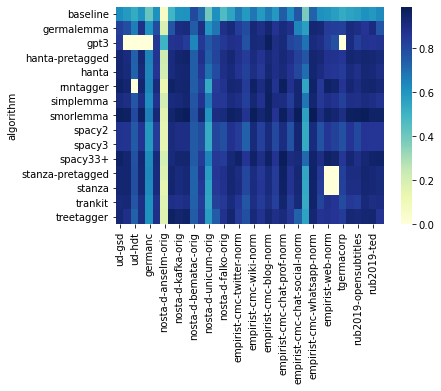

In [32]:
# accuracy
generate_table(data, ['metrics','overall','accuracy'])

\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
\textbf{algorithm} &  baseline &  germalemma &    gpt3 &  hanta-pretagged &   hanta &  rnntagger &  simplemma &  smorlemma &  spacy2 &  spacy3 &  spacy33+ &  stanza-pretagged &  stanza &  trankit &  treetagger \\
\midrule
\textbf{ud-gsd                       } &    0.6262 &      0.8343 &  0.8521 &           0.9426 &  0.9401 &     0.9589 &     0.9089 &     0.9714 &  0.8755 &  0.8755 &    0.9595 &            0.9414 &  0.9412 &   0.9231 &      0.9306 \\
\textbf{ud-pud                       } &    0.5897 &      0.7921 &  0.0000 &           0.9112 &  0.9184 &     0.9383 &     0.8988 &     0.9649 &  0.8719 &  0.8719 &    0.9410 &            0.9401 &  0.9421 &   0.9274 &      0.8923 \\
\textbf{ud-hdt                       } &    0.5361 &      0.6648 &  0.0000 &           0.7346 &  0.7294 &     0.0000 &     0.7630 &     0.8038 &  0.7520 &  0.7520 &    0.7790 &            0.7855 &  0.7848 &   0.7681 &      0.7352 \\
\textbf{germanc-norm                

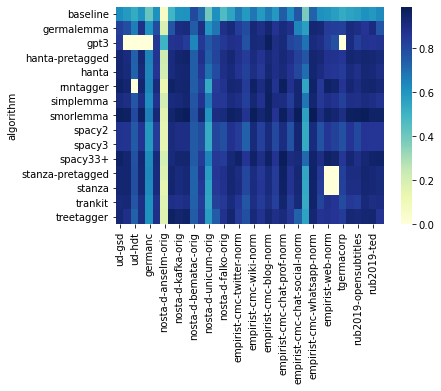

In [35]:
accuracy = generate_table(data, ['metrics','overall','accuracy']).T
print(accuracy.to_latex(bold_rows=True))

## Energieverbrauchsaspekte

,ud-gsd,ud-pud,ud-hdt,germanc-norm,germanc,nosta-d-tuebadz-orig,nosta-d-anselm-orig,nosta-d-anselm-norm,nosta-d-kafka-orig,nosta-d-kafka-norm,...,empirist-cmc-whatsapp-norm,empirist-cmc-whatsapp,empirist-web-norm,empirist-web,tgermacorp,rub2019-novelette,rub2019-opensubtitles,rub2019-sermononline,rub2019-ted,rub2019-wikipedia
algorithm,,,,,,,,,,,,,,,,,,,,,
baseline,0.0034,0.0025,0.0033,0.0020,0.0032,0.0018,0.0027,0.0028,0.0025,0.0019,...,0.0019,0.0024,0.0018,0.0018,0.0021,0.0020,0.0016,0.0027,0.0033,0.0027
germalemma,0.1268,0.2138,2.4230,0.2997,0.4231,0.0620,0.0694,0.0115,0.0335,0.0253,...,0.0068,0.0053,0.0693,0.0286,0.8729,0.0142,0.0145,0.0128,0.0182,0.0227
gpt3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
hanta-pretagged,3.6050,7.4927,85.3678,10.6282,11.1421,1.3463,0.3065,0.2802,0.9301,1.0180,...,0.2850,0.2774,1.2277,1.2285,31.0562,0.3113,0.2984,0.2860,0.3848,0.3911
hanta,6.6918,9.0625,164.1077,20.7851,22.0978,2.3338,0.4461,0.4493,1.7773,1.7370,...,0.3411,0.3602,2.1880,2.2137,59.3172,0.5317,0.4486,0.4970,0.6687,0.6976
rnntagger,47.8333,53.2712,0.0000,102.4034,109.0002,17.9884,5.8781,5.5842,13.1983,12.8012,...,4.9486,4.9155,17.9885,19.1512,267.0366,7.0435,7.1692,6.6523,6.7659,7.6445
simplemma,1.0418,0.0865,0.6255,0.1524,0.1623,0.0252,0.0110,0.0083,0.0218,0.0117,...,0.0064,0.0055,0.0252,0.0146,0.3318,0.0099,0.0128,0.0093,0.0103,0.0102
smorlemma,16774.3872,23384.0738,459661.5246,61205.3442,60608.1469,5975.3396,1510.1758,1513.0312,5747.1933,5743.8877,...,616.3476,615.7268,5222.9907,5269.6059,178234.0100,1767.0568,2032.0497,1669.2459,1956.6802,1790.6311
spacy2,2.3505,2.8530,45.5724,7.2228,7.0720,0.9405,0.2013,0.3626,0.8008,0.7956,...,0.1771,0.1710,0.6467,0.6478,26.1597,0.2447,0.5565,0.2693,0.3396,0.2985


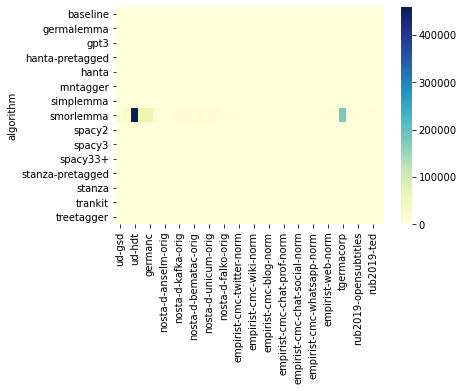

In [68]:
generate_table(data, 'elapsed')

,ud-gsd,ud-pud,ud-hdt,germanc-norm,germanc,nosta-d-tuebadz-orig,nosta-d-anselm-orig,nosta-d-anselm-norm,nosta-d-kafka-orig,nosta-d-kafka-norm,...,empirist-cmc-whatsapp-norm,empirist-cmc-whatsapp,empirist-web-norm,empirist-web,tgermacorp,rub2019-novelette,rub2019-opensubtitles,rub2019-sermononline,rub2019-ted,rub2019-wikipedia
algorithm,,,,,,,,,,,,,,,,,,,,,
baseline,440.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
germalemma,5447358.0000,1157240.0000,24287155.0000,2284435.0000,2506477.0000,364904.0000,18403884.0000,34390.0000,164892.0000,128253.0000,...,19036.0000,16128.0000,287331.0000,125763.0000,8749788.0000,43107.0000,50470.0000,38671.0000,63643.0000,94419.0000
gpt3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
hanta-pretagged,995702.0000,1360842.0000,20494229.0000,3497404.0000,3566768.0000,373466.0000,18412743.0000,106703.0000,359621.0000,357169.0000,...,98185.0000,98788.0000,340638.0000,340683.0000,10179115.0000,105500.0000,117590.0000,102364.0000,116893.0000,106757.0000
hanta,997943.0000,1365049.0000,20496702.0000,3498253.0000,3565036.0000,388657.0000,88686.0000,106357.0000,364362.0000,361123.0000,...,98060.0000,98246.0000,349510.0000,349927.0000,10180823.0000,106645.0000,126550.0000,106004.0000,119606.0000,116649.0000
rnntagger,1486808.0000,1805567.0000,0.0000,3770495.0000,3973581.0000,530788.0000,311926.0000,321449.0000,572593.0000,582888.0000,...,304728.0000,304601.0000,586520.0000,586317.0000,10250357.0000,353216.0000,324096.0000,320304.0000,359795.0000,360065.0000
simplemma,172762441.0000,1366765.0000,12944762.0000,1599584.0000,1447532.0000,201869.0000,72040.0000,29079.0000,109719.0000,62416.0000,...,16008.0000,11760.0000,163683.0000,58460.0000,4396501.0000,28136.0000,44418.0000,26928.0000,36804.0000,58051.0000
smorlemma,749707.0000,909519.0000,8749618.0000,1799696.0000,1785655.0000,485821.0000,137825.0000,266762.0000,488925.0000,469380.0000,...,153244.0000,149540.0000,458153.0000,458281.0000,4494133.0000,261473.0000,286209.0000,247645.0000,288603.0000,267231.0000
spacy2,13828735.0000,18502993.0000,353280573.0000,43076537.0000,43734419.0000,4463338.0000,1329946.0000,1296915.0000,4062236.0000,4063703.0000,...,600305.0000,601734.0000,4254867.0000,4204755.0000,137431931.0000,1353182.0000,1968780.0000,1192590.0000,1312911.0000,1209149.0000


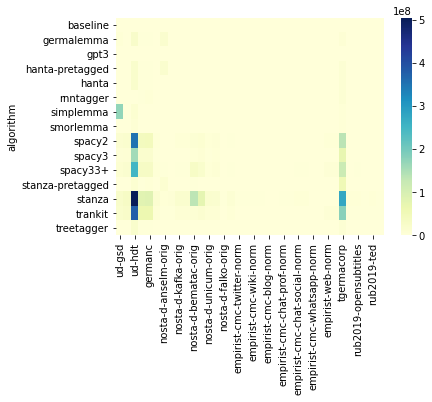

In [69]:
generate_table(data, 'memory_peak')

,ud-gsd,ud-pud,ud-hdt,germanc-norm,germanc,nosta-d-tuebadz-orig,nosta-d-anselm-orig,nosta-d-anselm-norm,nosta-d-kafka-orig,nosta-d-kafka-norm,...,empirist-cmc-whatsapp-norm,empirist-cmc-whatsapp,empirist-web-norm,empirist-web,tgermacorp,rub2019-novelette,rub2019-opensubtitles,rub2019-sermononline,rub2019-ted,rub2019-wikipedia
algorithm,,,,,,,,,,,,,,,,,,,,,
baseline,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
germalemma,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000
gpt3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
hanta-pretagged,0.0002,0.0004,0.0051,0.0006,0.0007,0.0001,0.0000,0.0000,0.0001,0.0001,...,0.0000,0.0000,0.0001,0.0001,0.0018,0.0000,0.0000,0.0000,0.0000,0.0000
hanta,0.0004,0.0005,0.0097,0.0012,0.0013,0.0001,0.0000,0.0000,0.0001,0.0001,...,0.0000,0.0000,0.0001,0.0001,0.0035,0.0000,0.0000,0.0000,0.0000,0.0000
rnntagger,0.0031,0.0036,0.0000,0.0068,0.0072,0.0012,0.0004,0.0004,0.0009,0.0008,...,0.0003,0.0003,0.0012,0.0013,0.0179,0.0005,0.0005,0.0004,0.0004,0.0005
simplemma,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
smorlemma,0.9901,1.3758,31.8529,3.6077,3.5836,0.3529,0.0890,0.0894,0.3391,0.3399,...,0.0363,0.0362,0.3070,0.3097,10.7163,0.1246,0.1434,0.1175,0.1382,0.1274
spacy2,0.0001,0.0002,0.0026,0.0004,0.0004,0.0001,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0015,0.0000,0.0000,0.0000,0.0000,0.0000


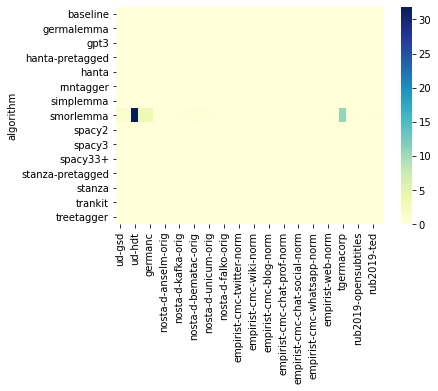

In [70]:
generate_table(data, 'energy_consumed')

### PoS-Tags

In [71]:
# comparison by pos tag
def analysis_by_pos(dataset, metric='accuracy', split_uxpos=True):
    pos = pd.DataFrame(dtype='float')
    for item in data:
        lem = item["lemmatizer"]
        if (item['dataset'] == dataset) and (item["lemmatizer"] in algos) and \
        (item["lemmatizer"] not in pos.columns) and ('metrics' in item):
            tmp = pd.DataFrame.from_dict(item['metrics']).T
            tmp[lem] = tmp[metric]
            pos = pd.merge(pos, tmp[lem], left_index=True, right_index=True, how='right')
    dfs = [pos]
    if split_uxpos:
        # UPOS and XPOS tags
        upos, xpos = pos.iloc[1:6,:], pos.iloc[6:,:]
        dfs += [upos, xpos]
    return dfs

In [72]:
pos, upos, xpos = analysis_by_pos("nosta-d-tuebadz-orig")

In [73]:
upos

,baseline,germalemma,gpt3,hanta-pretagged,hanta,rnntagger,simplemma,smorlemma,spacy2,spacy3,spacy33+,stanza-pretagged,stanza,trankit,treetagger
ADJ,0.3131,0.8384,0.7682,0.8662,0.8662,0.8384,0.8131,0.9470,0.7298,0.7298,0.8763,0.9141,0.9066,0.8359,0.8838
ADV,0.8542,0.9695,0.8757,0.9729,0.9627,0.9627,0.9763,0.9797,0.8339,0.8339,0.9695,0.9729,0.9729,0.9593,0.9627
NOUN,0.7231,0.9084,0.8432,0.8200,0.8168,0.8967,0.9052,0.8924,0.8530,0.8530,0.9010,0.8988,0.8946,0.8775,0.9276
PROPN,0.9481,0.0000,0.8889,0.8734,0.8442,0.9610,0.9545,0.9610,0.9578,0.9578,0.9805,0.9448,0.9448,0.9351,0.7143
VERB,0.2965,0.9162,0.9333,0.9080,0.9080,0.9264,0.7730,0.9223,0.8528,0.8528,0.9100,0.8937,0.8896,0.8487,0.8978


In [80]:
print(upos.T.to_latex(bold_rows=True))

\begin{tabular}{llllll}
\toprule
{} &    ADJ &    ADV &   NOUN &  PROPN &   VERB \\
\midrule
\textbf{baseline        } & 0.3131 & 0.8542 & 0.7231 & 0.9481 & 0.2965 \\
\textbf{germalemma      } & 0.8384 & 0.9695 & 0.9084 & 0.0000 & 0.9162 \\
\textbf{gpt3            } & 0.7682 & 0.8757 & 0.8432 & 0.8889 & 0.9333 \\
\textbf{hanta-pretagged } & 0.8662 & 0.9729 & 0.8200 & 0.8734 & 0.9080 \\
\textbf{hanta           } & 0.8662 & 0.9627 & 0.8168 & 0.8442 & 0.9080 \\
\textbf{rnntagger       } & 0.8384 & 0.9627 & 0.8967 & 0.9610 & 0.9264 \\
\textbf{simplemma       } & 0.8131 & 0.9763 & 0.9052 & 0.9545 & 0.7730 \\
\textbf{smorlemma       } & 0.9470 & 0.9797 & 0.8924 & 0.9610 & 0.9223 \\
\textbf{spacy2          } & 0.7298 & 0.8339 & 0.8530 & 0.9578 & 0.8528 \\
\textbf{spacy3          } & 0.7298 & 0.8339 & 0.8530 & 0.9578 & 0.8528 \\
\textbf{spacy33+        } & 0.8763 & 0.9695 & 0.9010 & 0.9805 & 0.9100 \\
\textbf{stanza-pretagged} & 0.9141 & 0.9729 & 0.8988 & 0.9448 & 0.8937 \\
\textbf{stanza     

In [74]:
xpos

,baseline,germalemma,gpt3,hanta-pretagged,hanta,rnntagger,simplemma,smorlemma,spacy2,spacy3,spacy33+,stanza-pretagged,stanza,trankit,treetagger
ADJA,0.1103,0.8007,0.7469,0.8363,0.8363,0.7865,0.7651,0.9253,0.6975,0.6975,0.8505,0.9039,0.8932,0.8114,0.8612
PAV,0.7143,0.8929,0.6667,0.9286,0.9286,0.9286,0.9286,0.9286,0.7857,0.7857,0.9286,0.9286,0.9286,0.9286,0.9286
VMPP,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
VVFIN,0.1885,0.8934,0.9308,0.8730,0.8730,0.8893,0.7992,0.8975,0.8279,0.8279,0.8689,0.8607,0.8525,0.8115,0.8648
VVINF,0.9630,0.9630,0.9444,0.9630,0.9630,0.9630,0.9630,0.9630,0.9630,0.9630,0.9630,0.9506,0.9506,0.9136,0.9630
VVPP,0.0778,0.9333,0.9200,0.9444,0.9444,0.9778,0.4444,0.9333,0.8889,0.8889,0.9556,0.8778,0.8778,0.8444,0.9000
PWAV,0.6667,1.0000,0.8000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
NN,0.7231,0.9084,0.8432,0.8200,0.8168,0.8967,0.9052,0.8924,0.8530,0.8530,0.9010,0.8988,0.8946,0.8775,0.9276
VMFIN,0.1452,0.9355,0.9302,0.9032,0.9032,0.9355,0.8548,0.9516,0.7258,0.7258,0.9194,0.9516,0.9516,0.9032,0.9194
NE,0.9481,0.0000,0.8889,0.8734,0.8442,0.9610,0.9545,0.9610,0.9578,0.9578,0.9805,0.9448,0.9448,0.9351,0.7143


In [75]:
def pos_figure(pos=pos):
    figure(figsize=(10, 10), dpi=144)
    plt.imshow(pos.to_numpy(dtype='float'))
    plt.xticks(range(len(pos.columns)), list(pos.columns), rotation=90)
    plt.yticks(range(len(pos.index)), pos.index, rotation=0)
    plt.colorbar();
    plt.show();

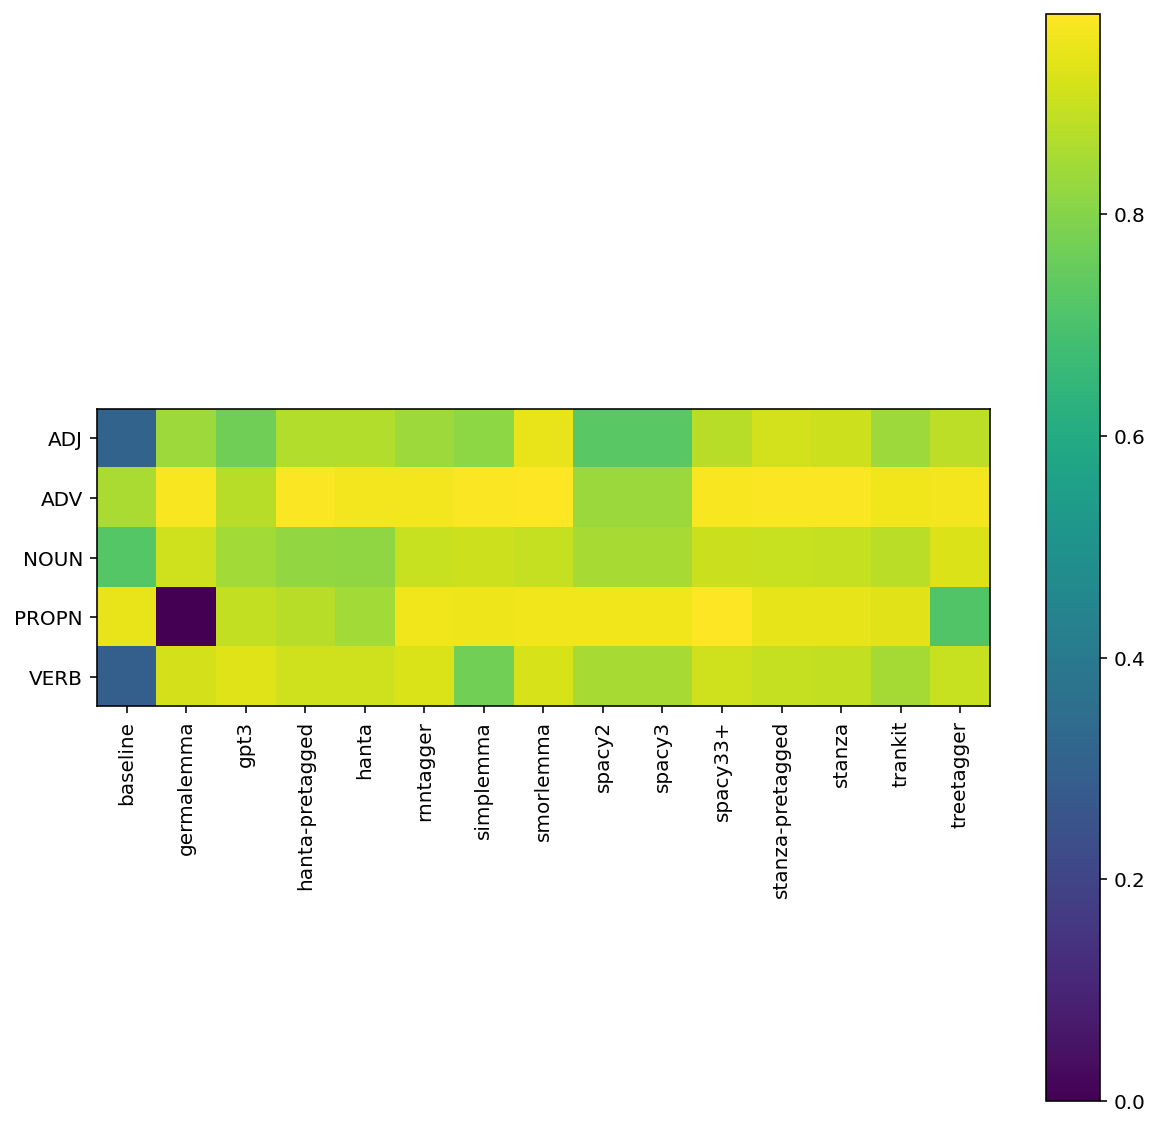

In [76]:
pos_figure(upos)

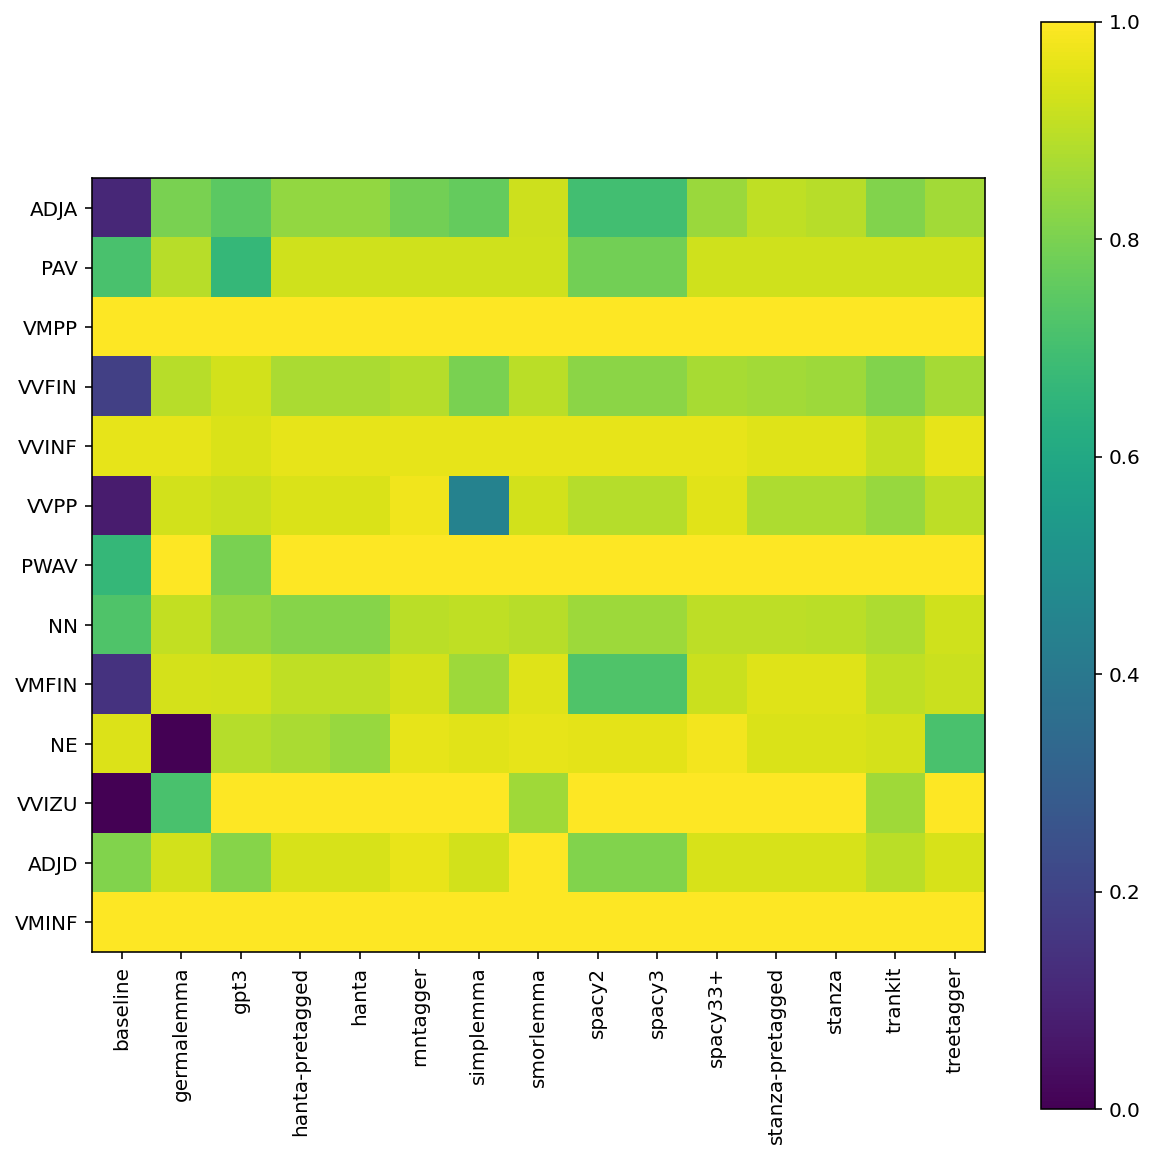

In [77]:
pos_figure(xpos)

Observations:
* baseline (unsurprisingly) performs best with least inflected word categories: adverbs and proper nouns
* germalemma performs worst on proper nouns
* simplemma (unlike other algos) performs better with adjectives, worse with verbs
* spacys(2,3,3.3): improved for almost all categories, but not proper nouns, interesting! 
* similar pattern for stanza & trankit: very good on all categories, worst on nouns and adjectives
* trankit and treetagger seem to struggle with finite verbs, infinitives (VVFIN, VVINF)